## Download Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/ERA_v1/Session10/dev_folder/dev2

/content/drive/MyDrive/ERA_v1/Session10/dev_folder/dev2


In [3]:
!pip install -r requirements.txt

## Import Libraries

In [4]:
# to debug
import pdb
#pdb.set_trace()

In [5]:
import os
import torch
from torchsummary import summary

## Import Custom Modules

In [6]:
from cifar.back_propogation import *
from cifar.cifar10_dataset import cifar10Set
from cifar.model import *
from cifar.utils import *
from cifar.scheduler import *
from cifar.model_training import *


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
SEED = 11

# Set seed for reproducibility
torch.manual_seed(SEED)

## Assign Device & Batch Size

In [8]:
# Check if GPU/CUDA is available
use_cuda, device = get_device()

if use_cuda:
    torch.cuda.manual_seed(SEED)

print(device)

cuda


In [9]:
if use_cuda:
  batch_size = 512
else:
  batch_size = 64

In [10]:
# used for debugging purposes
%xmode Verbose

Exception reporting mode: Verbose


## Load CIFAR10 Data Set

In [11]:
cifar10_data = cifar10Set(batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


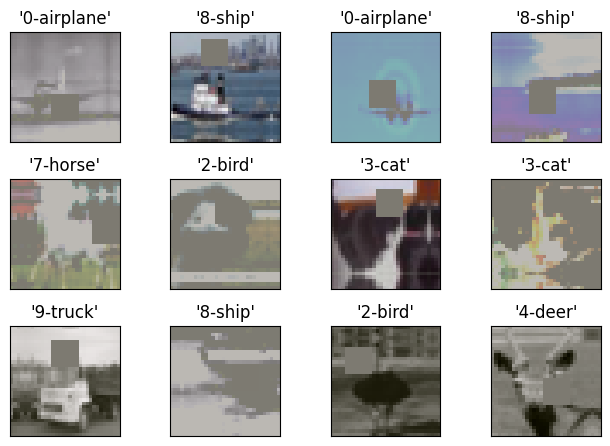

In [12]:
cifar10_data.show_dataset_images()

## Instantiate Model

In [13]:
model1 = custResNet(dropout=0.05)

In [14]:
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Param %
custResNet                               [512, 3, 32, 32]          [512, 10]                 --                        --                             --
├─custBlock: 1-1                         [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --                             --
│    └─convLayer: 2-1                    [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --                             --
│    │    └─Conv2d: 3-1                  [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]                      0.03%
│    │    └─BatchNorm2d: 3-2             [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --                          0.00%
│    │    └─ReLU: 3-3                    [512, 64, 32, 32]         [512, 64, 32, 3

In [15]:
# pdb.set_trace()

## Train Model

In [15]:
EPOCHS = 24

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.10E-04


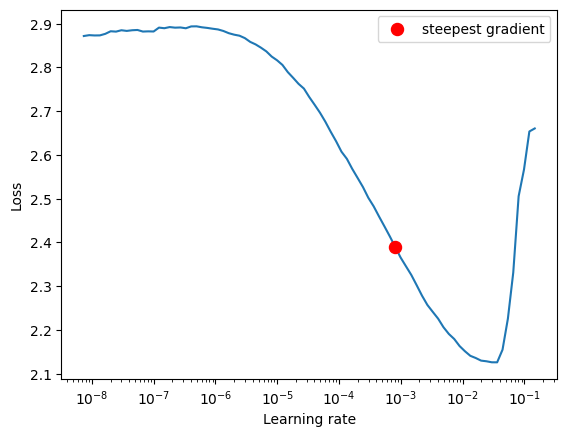

In [16]:
train_model1 = trainModel(model1, train, test,
                          cifar10_data.train_loader,
                          cifar10_data.test_loader, epochs=EPOCHS,
                          device=device)

In [17]:
train_model1.run_training_model()

| Epoch | LR       | Time    | TrainLoss | TrainAcc | TestLoss | TestAcc |
|     1 | 0.000032 | 00m 32s | 1.592224  |  32.39%  | 0.003475 |   38.6% |
|     2 | 0.000188 | 00m 30s | 1.359493  |  46.77%  | 0.002429 |   56.4% |
|     3 | 0.000344 | 00m 30s | 1.152689  |  55.42%  | 0.001898 |  66.23% |
|     4 | 0.000500 | 00m 31s | 1.092481  |  62.42%  | 0.001969 |  66.09% |
|     5 | 0.000656 | 00m 31s | 0.914025  |  64.81%  | 0.001552 |  73.65% |
|     6 | 0.000810 | 00m 30s | 0.928239  |   66.7%  | 0.001805 |  68.49% |
|     7 | 0.000767 | 00m 33s | 0.958703  |  69.23%  | 0.001353 |  76.97% |
|     8 | 0.000724 | 00m 32s | 0.898371  |   70.4%  | 0.001631 |  72.02% |
|     9 | 0.000682 | 00m 31s | 0.857317  |  71.35%  | 0.001282 |  78.28% |
|    10 | 0.000639 | 00m 32s | 0.781572  |  72.05%  | 0.001107 |  81.43% |
|    11 | 0.000597 | 00m 32s | 0.748792  |  72.89%  | 0.001245 |  77.54% |
|    12 | 0.000554 | 00m 31s | 0.855572  |  73.58%  | 0.001162 |  79.82% |
|    13 | 0.000512 | 00m 

## Plot Model Statistics

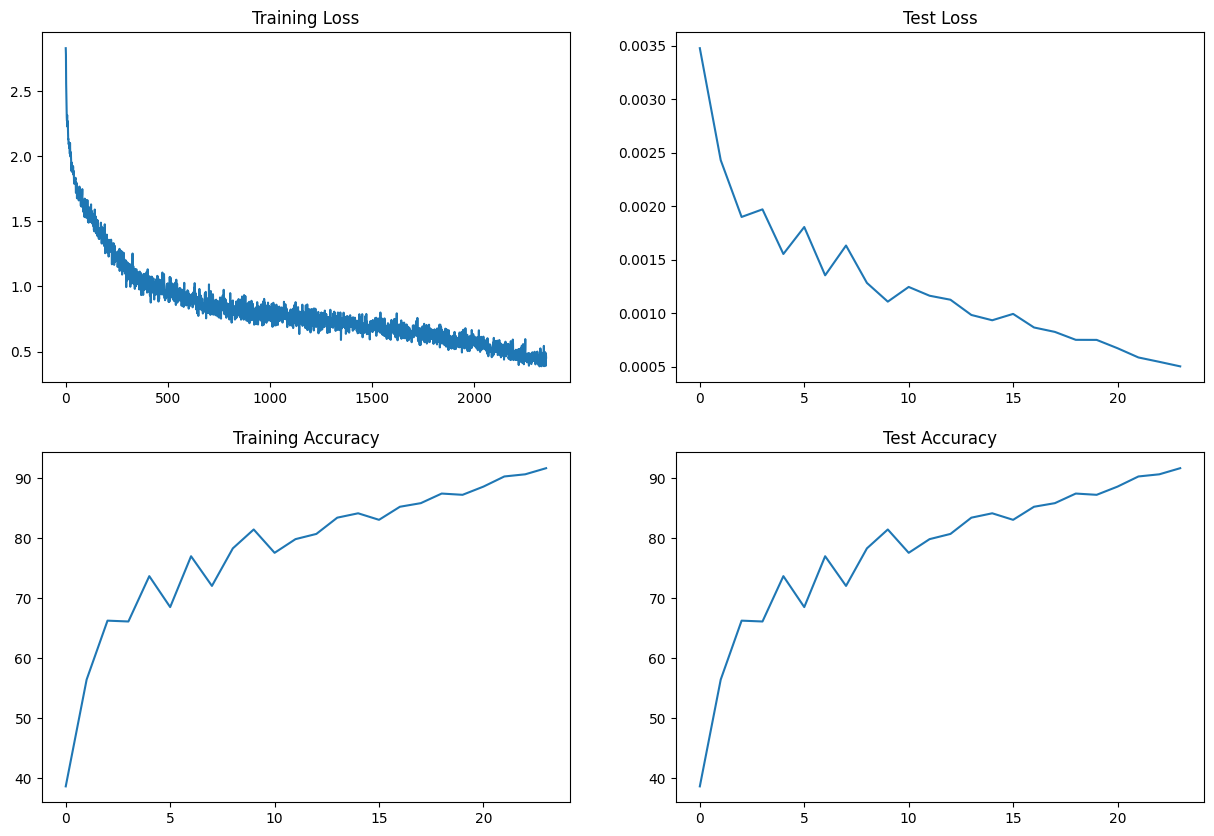

In [18]:
train_model1.display_model_stats()

In [19]:
train_model1.show_best_model()

Test Accuracy: 91.65% | Test Loss: 0.000502


## Display Incorrect Predictions

In [20]:
model1_incorrect_pred = get_incorrect_test_predictions(model1,
                                                    device,
                                                    cifar10_data.test_loader)

0 - 'airplane' 1 - 'automobile' 2 - 'bird' 3 - 'cat' 4 - 'deer' 5 - 'dog' 6 - 'frog' 7 - 'horse' 8 - 'ship' 9 - 'truck' 

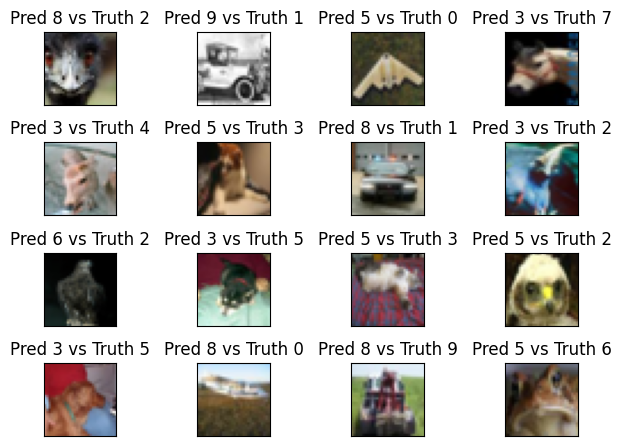

In [21]:
cifar10_data.show_cifar10_incorrect_predictions(denormalize=True,
                                                incorrect_prediction=model1_incorrect_pred)

## Observations & Insights

#### Code Block - Final Optimal Model


**Target:**

- Network Architecture - Dilated Convolution + Depthwise Separable Convolution
- Layer Structure - C1 C2 C3 C4 Output + No MaxPooling, all convolution blocks
have 3 layers and use 3x3 convolutions, GAP + FC + 1x1 convolutions
- Image Augmentation using Albumentation Transforms - Color Jitter + To Gray +
Horizontal flip + Shift Scale Rotate + Coarse Dropout
- Skip connections used
- Batch Normalization used
- Dropout of 0.05 and one cycle learning rate with max LR as 0.1 used
- L1 regularization degraded the performance and led the model to over-fitting,
hence it is not used
- The receptive field we got with this network architecture is 48

**Results:**

- Parameters: 190.509K
- Best Train Accuracy: 86.19%
- Best Test Accuracy: 87.22% (95th Epoch)
- Test Accuracy: 85.39% (59th Epoch) [First occurrence of test accuracy above 85%]

**Analysis:**
- Model has no over fitting through out the training
- Scheduling OneCycle LR with pct_start = 0.4 gave better train/test accuracies
trend in the first 100 epochs
  - Keeping the LR fixed at 0.1 did not show this kind of performance, the best
  test accuracy achieved with in first 100 epochs is only 86.83%